# Imports

Import all libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


# Checking the data

In [146]:
words_data_train = fetch_20newsgroups(subset='train')


In [147]:
for line in words_data_train.data[0].split("\n"):
    print(line)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [148]:
np.unique(words_data_train.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [149]:
words_data_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [150]:
words_data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [151]:
for i in words_data_train.DESCR.split("\n"):
    print(i)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

# Load Data Set

Function load_20newsgroups return the data and the target (X, Y)

In [2]:
def load_20newsgroups(subset='train', category=True):
    categories = [
        "alt.atheism",
        "comp.graphics",
        "comp.sys.ibm.pc.hardware",
        "misc.forsale",
        "rec.autos",
        "sci.space",
        "talk.religion.misc",
    ]

    if category:
        data = fetch_20newsgroups(subset=subset,categories=categories,shuffle=True,remove=('headers', 'footers', 'quotes'))
    else:
        data = fetch_20newsgroups(subset=subset,shuffle=True,remove=('headers', 'footers', 'quotes'))

    data_size_mb = sum(len(s.encode('utf-8')) for s in data.data) / 1e6
    print(f"{len(data.data)} documents - {data_size_mb:.3f}MB")

    return data.data, data.target, data.target_names


Function bench_k_means to verify some scores

In [3]:
def bench_k_means(estimator, data, y=None):
    estimator.fit(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]

    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            # with ground-truth
            # Yeah !
            score = getattr(metrics, s)(y, estimator.labels_)
        elif y is not None:
            # with NO ground-truth
            score = getattr(metrics, s)(data, estimator.labels_)
        else:
            continue
            
        results.append(score)
        
    return pd.DataFrame([results], columns=scores, index=["result"])

In [11]:
data_train, y_train, train_target_name = load_20newsgroups('train',category=True)
data_test, y_test, test_target_name = load_20newsgroups('test',category=True)


3803 documents - 3.703MB
2531 documents - 2.593MB


# CountVectorizer

First try with CountVectorizer, using max_df, min_df and stop_words to reduce the amount of data to be analyzed.

In [155]:
vectorizer = CountVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)

# vectorizer_test = CountVectorizer(max_df=0.5, min_df=2, stop_words='english')
# X_test = vectorizer_test.fit_transform(data_test)

K = len(np.unique(y_train))

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
kmeans.fit_transform(X_train)

df = bench_k_means(kmeans, X_train, y_train).round(2)
df

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                  0.0                         0.0              0.85  \

        homogeneity_score  completeness_score  v_measure_score  
result                0.0                0.15             0.01

# TfidfVectorizer

Second try, using TfidfVectorizer, with the same parameters (max, min and stop_word) in order to compare the outcome with CountVectorizer

In [174]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)

K = len(np.unique(y_train))

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
kmeans.fit_transform(X_train)

bench_k_means(kmeans, X_train, y_train).round(2)

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                 0.07                        0.34              0.01  \

        homogeneity_score  completeness_score  v_measure_score  
result               0.31                0.38             0.34

In [175]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [158]:
def frequencies_dict(cluster_index):
    if cluster_index > K - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = order_centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [159]:
def make_image(frequencies):

    wc = WordCloud(background_color="white")
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Creating a WordCloud with all works analyzed by group see the relation between them.

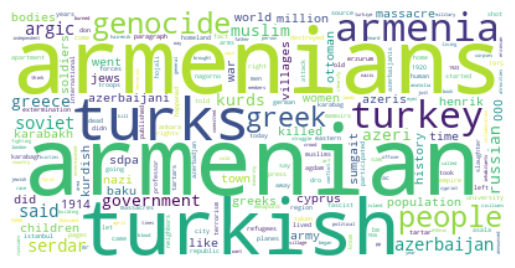

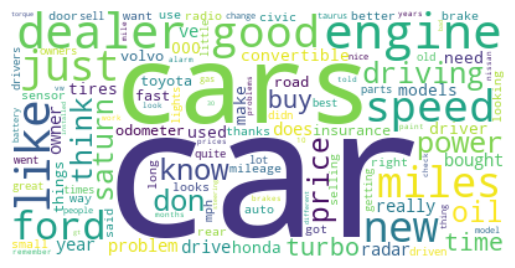

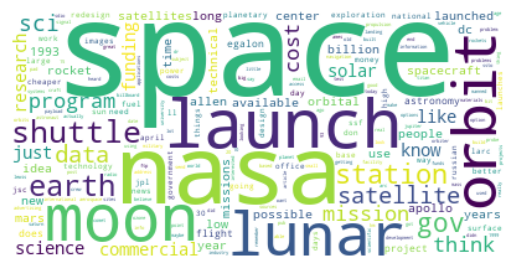

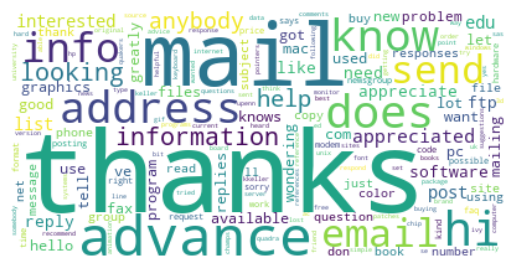

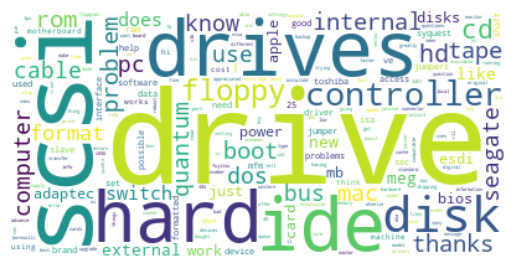

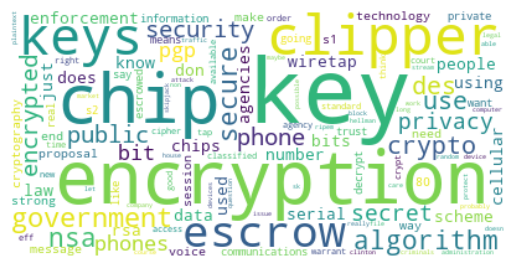

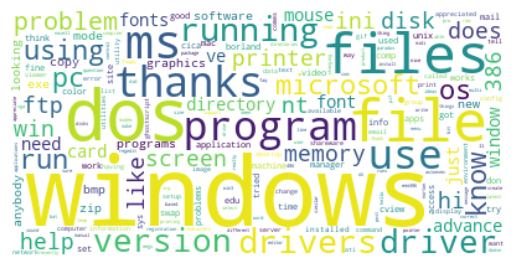

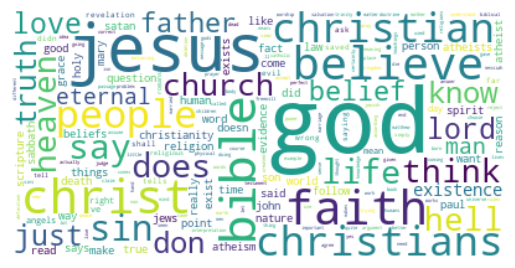

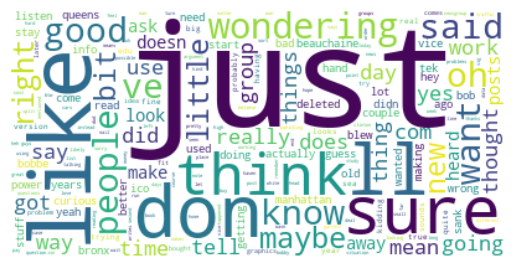

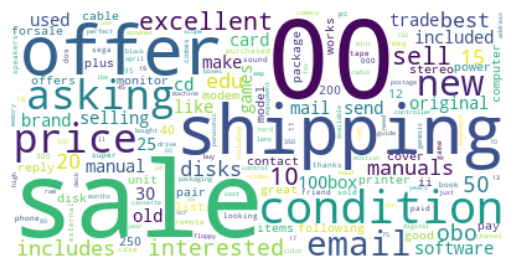

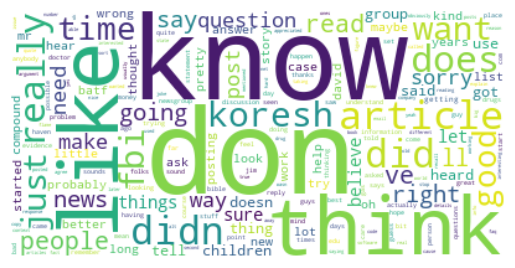

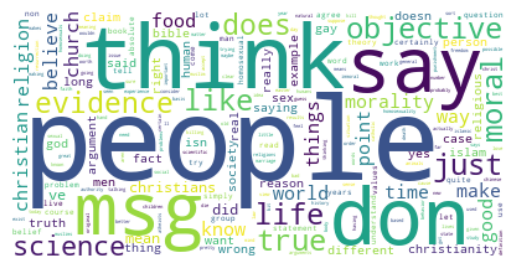

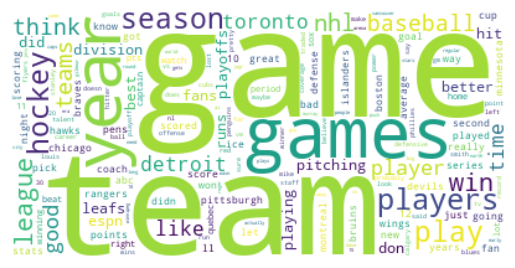

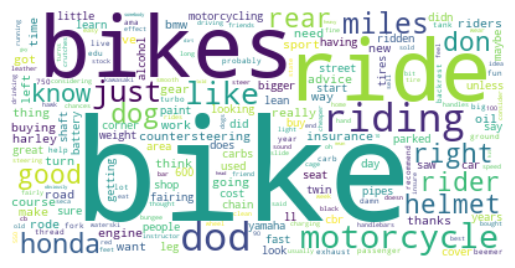

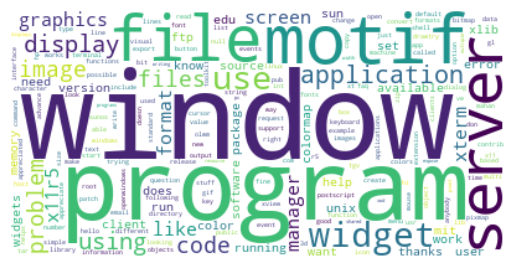

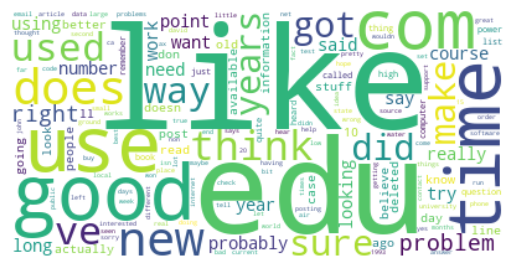

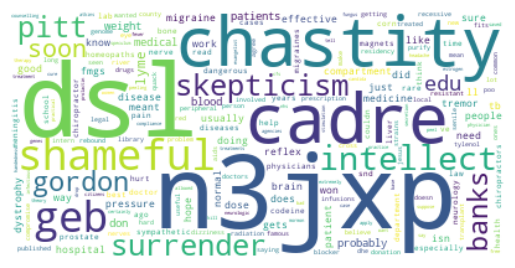

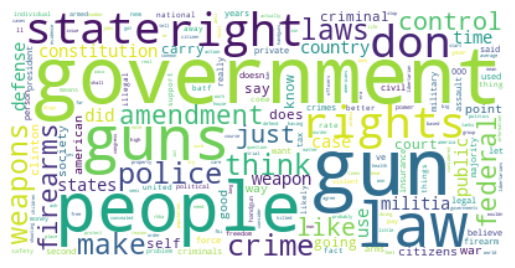

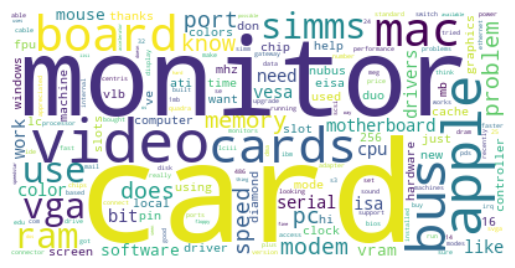

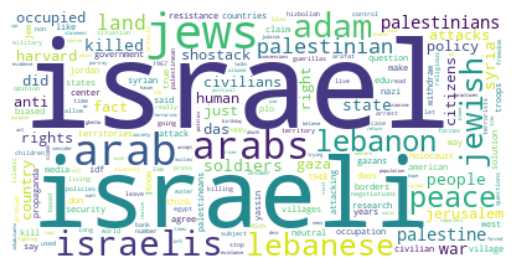

In [177]:
for i in range(K):
    freq = frequencies_dict(i)
    make_image(freq)
    print()

# TfidfVectorizer with TruncatedSVD

Using LSA to renduce and normalize the data, creating a x_lsa, that will be used to feed KMeans. 

In [161]:

n_components = 100
lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_train)

explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

kmeans = KMeans(init='k-means++',n_clusters=K, random_state=42)
bench_k_means(kmeans, X_lsa, y_train).round(2)

Explained variance of the SVD step: 10.5%


c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


adjusted_rand_score  adjusted_mutual_info_score  silhouette_score   
result                 0.18                        0.36              0.06  \

        homogeneity_score  completeness_score  v_measure_score  
result               0.35                0.37             0.36

In [162]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(K):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()

Cluster 0: 00 sale offer shipping price condition 10 new asking best email sell 50 interested 15 excellent 25 used 20 make 
Cluster 1: god jesus bible christ believe faith people christian christians say life does hell heaven church sin lord man think love 
Cluster 2: does like know new did post ll read article time ve say information got don didn right mail going looking 
Cluster 3: windows file window program files use using dos motif server problem application running code like version help widget run display 
Cluster 4: edu university cs email david ftp colorado send pub computer com uiuc article mail know mit just internet virginia adam 
Cluster 5: key chip encryption clipper keys government escrow algorithm use public secure nsa security phone des encrypted privacy law secret bit 
Cluster 6: thanks advance mail know hi does info looking help anybody information email appreciated post like tell address interested ftp appreciate 
Cluster 7: card video bus monitor drivers cards vga 

# LDA

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
lda = LatentDirichletAllocation(
    n_components=10000,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [12]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)

lda.fit_transform(X_train)
bench_k_means(lda, X_train, y_train).round(2)


# SVC

Using Classification to check the accuracy

In [165]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

In [166]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [169]:
cm = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred,target_names=test_target_name))

0.6791024960169941
                          precision    recall  f1-score   support

             alt.atheism       0.50      0.47      0.49       319
           comp.graphics       0.59      0.72      0.65       389
 comp.os.ms-windows.misc       0.70      0.61      0.65       394
comp.sys.ibm.pc.hardware       0.67      0.65      0.66       392
   comp.sys.mac.hardware       0.79      0.65      0.71       385
          comp.windows.x       0.89      0.67      0.76       395
            misc.forsale       0.80      0.78      0.79       390
               rec.autos       0.50      0.77      0.60       396
         rec.motorcycles       0.62      0.79      0.70       398
      rec.sport.baseball       0.86      0.79      0.82       397
        rec.sport.hockey       0.94      0.83      0.88       399
               sci.crypt       0.92      0.63      0.74       396
         sci.electronics       0.46      0.67      0.54       393
                 sci.med       0.77      0.77      0.77 